In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples2.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.A.22.R.A.36.R.G.48.,-_-_-,33.73_39.19_14.5,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0
1,1b23.cif1_R,120,R.A.22.R.G.27.R.G.48.,-_-_-,23.6_22.89_14.5,0,0,1,0,1,...,0,0,0,0,0,0,0,5,0,0
2,1b23.cif1_R,0,R.G.19.R.G.57.R.C.69.,-_-_-,6.31_36.36_36.59,0,0,1,0,0,...,1,0,0,0,1,0,0,4,1,0
3,1b23.cif1_R,0,R.H2U.20.R.U.43.R.5MU.54.,-_-_-,24.47_37.47_24.2,0,0,1,0,0,...,1,0,0,0,1,0,0,7,1,0
4,1b23.cif1_R,0,R.C.44.R.G.52.R.C.62.,-_cWW_-,29.87_10.48_32.96,0,1,0,1,0,...,0,0,0,0,0,0,0,7,1,0


In [4]:
triplexes.shape

(34510, 477)

In [3]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [4]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [5]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 1318, '3j79.cif1_A': 966, '3j7p.cif1_S2': 764, '6ha1.cif1_a': 644, '6az1.cif1_1': 585, '3j7a.cif1_A': 483, '5xyi.cif1_2': 429, '6d9j.cif1_2': 383, '1u6b.cif1_B': 78, '5fdv.cif1_1B': 67, '4wf9.cif1_Y': 62, '4gxy.cif1_A': 58, '6ek0.cif1_L7': 53, '5xxb.cif1_3': 47, '5xym.cif1_B': 44, '6ha1.cif1_B': 41, '4qk8.cif1_A': 37, '3f2x.cif1_X': 34, '4rdx.cif1_C': 33, '2der.cif1_D': 32, '4mgn.cif1_A': 31, '5lys.cif1_B': 30, '3dil.cif1_A': 28, '4qlm.cif1_A': 28, '5d8h.cif1_A': 26, '5hr7.cif1_D': 26, '1j1u.cif1_B': 25, '5aj0.cif1_Bv': 25, '5mrc.cif1_bb': 25, '3eph.cif1_E': 24, '4mgn.cif1_B': 24, '6gaw.cif1_BB': 23, '5u3g.cif1_B': 22, '5jup.cif1_EC': 21, '6az3.cif1_7': 21, '3npq.cif1_A': 20, '4lvw.cif1_A': 20, '4y1m.cif1_B': 20, '3tup.cif1_T': 19, '5e81.cif1_1K': 19, '6ek0.cif1_L8': 19, '3la5.cif1_A': 18, '4gcw.cif1_B': 18, '5ud5.cif1_C': 18, '1i6u.cif1_C': 17, '1mms.cif1_C': 16, '4lx6.cif1_A': 15, '4v9k.cif1_AW': 15, '4wsm.cif1_3L': 12, '1s03.cif1_B': 11, '3e5c.cif

111 2.A.10.2.A.952.2.A.1108. cWW_tSW_cWS 12.17_9.05_5.6 PROBA:  0.042844620157558466
111 2.U.11.2.A.951.2.G.1107. cWW_-_cSS 10.81_12.63_5.74 PROBA:  0.46522112768133284
111 2.U.30.2.A.399.2.A.516. tWH_cWS_- 9.59_9.51_8.37 PROBA:  0.37623171159760693
111 2.A.45.2.U.87.2.A.316. cHS_cWW_- 7.66_10.6_12.33 PROBA:  0.42083014269275404
111 2.U.62.2.A.75.2.A.140. cWW_cSW_- 10.05_6.76_11.31 PROBA:  0.19970977345747548
111 2.G.294.2.G.307.2.A.604. tHW_-_tSW 11.05_19.57_9.59 PROBA:  0.2877936297679719
111 2.A.470.2.A.478.2.U.512. -_cSS_cWW 12.63_4.13_10.5 PROBA:  0.4128984775886626
111 2.A.707.2.G.745.2.A.808. cWW_tSS_- 13.22_4.9_11.47 PROBA:  0.22731156080509474
111 2.G.798.2.G.1554.2.C.1567. tSS_cWW_- 8.03_11.08_6.34 PROBA:  0.39831886904553576
111 2.A.1011.2.G.1360.2.A.1403. tWS_-_tHW 10.03_6.46_12.38 PROBA:  0.3314657727148561
111 2.G.1020.2.U.1050.2.C.1261. cSW_-_cWW 9.05_11.44_10.91 PROBA:  0.28517752565014803
111 2.C.1044.2.G.1053.2.U.1058. cHH_tWW_cWW 10.17_12.56_11.12 PROBA:  0.378463031

111 5.C.28.5.G.29.5.C.53. cWH_cWW_- 6.01_10.18_13.53 PROBA:  0.33007472083865397
111 5.A.70.5.G.314.5.C.323. tWS_cWW_- 9.95_10.41_11.31 PROBA:  0.48015607041020913
111 5.C.126.5.G.127.5.C.141. cWH_cWW_- 6.22_10.27_13.67 PROBA:  0.20574068430559855
111 5.A.162.5.U.272.5.U.273. cWW_-_cWW 13.54_6.61_10.82 PROBA:  0.36461288170593364
111 5.C.183.5.G.189.5.C.252. -_cWW_tW. 7.91_10.91_11.12 PROBA:  0.48411922361733484
111 5.U.206.5.A.208.5.G.232. tSH_tSS_- 6.79_5.44_11.77 PROBA:  0.22544346139322857
111 5.U.291.5.G.293.5.G.315. tSH_cSH_- 6.52_7.61_13.82 PROBA:  0.11789733795675343
111 5.A.318.5.A.3726.5.U.4359. -_tWS_cWW 9.36_9.28_10.42 PROBA:  0.2761348063909462
111 5.G.444.5.A.1303.5.A.2313. cWW_-_tSS 13.03_7.7_7.96 PROBA:  0.17294023575365366
111 5.C.447.5.G.448.5.C.1298. cWH_cWW_- 5.69_10.36_13.62 PROBA:  0.3413086614996296
111 5.C.707.5.G.1290.5.C.4942. cWW_tSH_- 10.72_9.97_8.26 PROBA:  0.27123492810377153
111 5.C.977.5.G.978.5.C.1276. cWH_cWW_- 5.17_10.53_13.81 PROBA:  0.21590489938569

111 1K.U.8.1K.A.14.1K.A.21. tWH_tWS_tSW 9.7_10.8_8.66 PROBA:  0.48424713629297295
111 1K.G.10.1K.C.25.1K.G.45. cWW_-_cHS 11.35_15.68_10.18 PROBA:  0.2875462201729524
CONFUSION MATRIX By chain:  5e81.cif1_1K
[[16  0]
 [ 2  1]]

111 A.A.23.A.G.69.A.A.127. cWW_tSW_- 12.88_9.92_13.4 PROBA:  0.38142666894387167
111 A.U.24.A.G.68.A.A.126. -_cWH_cSW 12.42_10.96_9.21 PROBA:  0.25725346847295
123 A.A.65.A.G.68.A.G.69. -_-_- 14.95_5.48_17.87 PROBA:  0.5359495108048778
CONFUSION MATRIX By chain:  3dil.cif1_A
[[23  1]
 [ 2  2]]

112 E.G.12.E.C.23.E.C.48. cWW_-_- 10.74_15.01_16.12 PROBA:  0.5590389062627529
111 E.U.8.E.A.14.E.A.21. tWH_cWS_tSW 9.47_10.23_8.55 PROBA:  0.46731608645137274
111 E.G.15.E.U.47.E.C.48. -_cSH_tWW 14.36_6.01_10.54 PROBA:  0.11202458733756206
CONFUSION MATRIX By chain:  3eph.cif1_E
[[19  1]
 [ 2  2]]

0 Y.U.38.Y.G.92.Y.C.104. -_-_- 76.05_40.09_46.48 PROBA:  0.5230948812127548
0 Y.U.12.Y.U.72.Y.U.83. -_-_- 20.09_34.67_50.45 PROBA:  0.6535620395789604
112 Y.C.26.Y.A.27.Y.U.53.

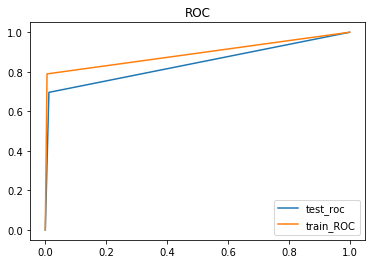

Probability density for train


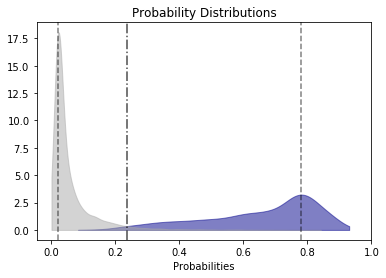

Probability density for test


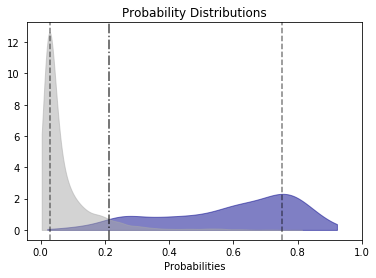


[[5816   70]
 [ 309  707]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5816   70  5886
1           309  707  1016
All        6125  777  6902


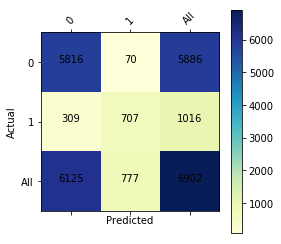


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5886
          1       0.91      0.70      0.79      1016

avg / total       0.94      0.95      0.94      6902

ACCURACY =  0.945088380179658
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 1152, '4ioa.cif1_X': 992, '5mrc.cif1_A': 832, '6d9j.cif1_5': 727, '5ool.cif1_A': 572, '3jam.cif1_2': 506, '5mrc.cif1_aa': 419, '5t5h.cif1_A': 340, '4p95.cif1_A': 92, '1u9s.cif1_A': 73, '4v9f.cif1_9': 63, '4ioa.cif1_Y': 59, '3j79.cif1_B': 55, '4r4v.cif1_A': 48, '4plx.cif1_A': 46, '5fjc.cif1_A': 42, '6d90.cif1_4': 38, '4oqu.cif1_A': 36, '3u4m.cif1_B': 33, '6d9j.cif1_7': 33, '4yco.cif1_D': 31, '4wj4.cif1_B': 29, '5e6m.cif1_C': 29, '2du3.cif1_D': 27, '2gdi.cif1_X': 26, '4p5j.cif1_A': 26, '1il2.cif1_C': 25, '1n78.cif1_C': 25, '3q3z.cif1_V': 25, '1u0b.cif1_A': 24, '2csx.cif1_C': 24, '4qei.cif1_C': 24, '4lck.cif1_B': 22, '3j7q.cif1_8': 21, '5hr6.cif1_C': 21, '2d6f.cif1_F': 20, '4fen.cif1_B':

111 aa.A.58.aa.U.114.aa.A.319. cHS_cWW_- 7.67_10.64_12.33 PROBA:  0.3061626614104182
111 aa.U.72.aa.G.202.aa.U.222. cSS_cWW_- 6.11_10.43_10.21 PROBA:  0.18588082324777466
111 aa.C.74.aa.G.102.aa.A.155. cWW_tSW_- 10.65_10.13_10.33 PROBA:  0.3271736558321096
111 aa.A.131.aa.G.236.aa.A.267. cWW_tSW_- 12.83_8.34_9.67 PROBA:  0.2685236775480599
111 aa.A.148.aa.U.223.aa.A.224. -_cWH_cWW 15.88_5.54_12.3 PROBA:  0.3216555014887158
111 aa.U.158.aa.G.201.aa.U.223. cHS_cWW_- 5.56_10.7_12.9 PROBA:  0.2115375314768832
111 aa.G.684.aa.G.685.aa.C.945. cSH_-_cWW 6.57_9.76_10.54 PROBA:  0.2701029297669279
111 aa.A.686.aa.A.794.aa.U.829. -_tWS_cWW 10.84_8.82_10.53 PROBA:  0.3675953920113459
111 aa.C.1013.aa.G.1265.aa.U.1433. cWW_cSS_- 10.83_7.12_9.11 PROBA:  0.47518861809619994
111 aa.U.1026.aa.A.1039.aa.A.1233. t.W_-_tWW 13.7_11.44_10.6 PROBA:  0.4899029667105043
111 aa.U.1033.aa.G.1108.aa.C.1227. cWS_cWW_- 5.59_10.72_9.71 PROBA:  0.23756157594275337
111 aa.U.1117.aa.G.1141.aa.A.1152. tHW_-_cWW 11.5_14

111 V.G.38.V.A.70.V.C.72. -_cSH_cWW 13.37_9.96_10.79 PROBA:  0.4876747987037018
111 V.G.39.V.A.70.V.C.71. -_cSH_cWW 13.26_7.01_10.73 PROBA:  0.43760336470632943
111 V.G.40.V.A.61.V.C.68. -_tWH_cWW 14.95_12.65_10.49 PROBA:  0.36909939518199
111 V.C.41.V.G.62.V.G.67. -_tWH_cWW 14.11_11.78_10.78 PROBA:  0.45676771177134207
CONFUSION MATRIX By chain:  3q3z.cif1_V
[[21  0]
 [ 4  0]]

112 A.G.2543.A.G.2544.A.A.2565. -_tSS_- 5.27_8.29_12.8 PROBA:  0.5930048598019589
CONFUSION MATRIX By chain:  3moj.cif1_A
[[7 1]
 [0 2]]

112 D.U.908.D.G.909.D.A.946. -_-_- 6.51_3.57_6.23 PROBA:  0.6147923792500322
111 D.U.908.D.A.914.D.A.946. tWH_t.W_- 10.42_13.67_6.23 PROBA:  0.2248025311490635
111 D.G.909.D.G.913.D.U.921. tHW_tSH_- 11.31_9.97_12.28 PROBA:  0.46403162021680144
111 D.G.916.D.U.920.D.A.958. -_cHW_tSS 10.53_12.84_8.63 PROBA:  0.26002845923579776
CONFUSION MATRIX By chain:  2du3.cif1_D
[[22  1]
 [ 3  1]]

111 7.G.9.7.G.12.7.A.22. -_cWW_tHH 11.53_12.17_11.32 PROBA:  0.3450566024485001
CONFUSION MA

CONFUSION MATRIX By chain:  1kxk.cif1_A
[[6 0]
 [0 1]]

111 C.C.13.C.G.36.C.A.43. cWW_tSS_- 10.64_8.39_5.55 PROBA:  0.44032111119754314
111 C.A.26.C.U.41.C.A.42. c.W_cSH_- 12.9_6.49_16.56 PROBA:  0.2110263866664451
CONFUSION MATRIX By chain:  4rge.cif1_C
[[15  0]
 [ 2  0]]

111 A.A.1718.A.C.1911.A.G.2008. cSS_cWW_- 5.7_10.53_12.44 PROBA:  0.4271887423017678
111 A.G.1719.A.C.1910.A.G.2009. -_cWW_tSS 6.16_10.68_7.77 PROBA:  0.44789859342325405
111 A.A.1723.A.U.1728.A.G.1750. -_tWW_cSW 11.76_11.62_7.62 PROBA:  0.4625618433740321
111 A.A.1724.A.U.2035.A.G.2040. -_cWW_tWS 11.38_9.84_9.44 PROBA:  0.4187251668256748
111 A.C.1726.A.G.1748.A.A.2919. cWW_tSH_- 10.56_6.69_11.86 PROBA:  0.22394277569410065
111 A.U.1738.A.U.1759.A.G.1888. cWW_-_tSW 8.94_8.57_8.5 PROBA:  0.24583411348154127
111 A.C.1769.A.C.2276.A.G.2289. -_cWW_tWS 5.27_10.51_8.63 PROBA:  0.22987485794419965
111 A.U.1774.A.A.1863.A.U.2302. tWW_cWW_cWS 10.64_10.63_5.94 PROBA:  0.34256495779847385
111 A.A.1789.A.C.1915.A.G.2004. cSS_c

AUC_TRAIN =  0.8853278410056056

AUC =  0.8277122995454935


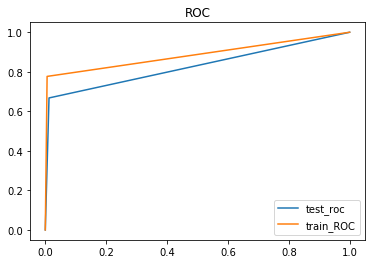

Probability density for train


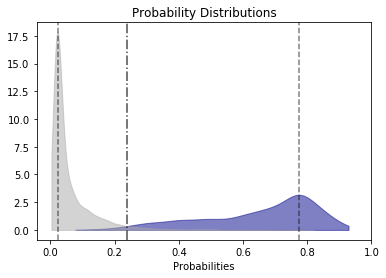

Probability density for test


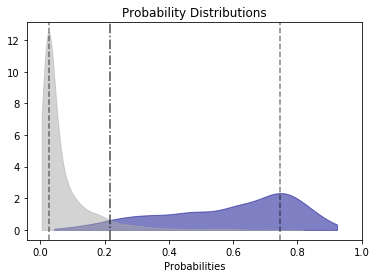


[[5816   72]
 [ 337  677]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5816   72  5888
1           337  677  1014
All        6153  749  6902


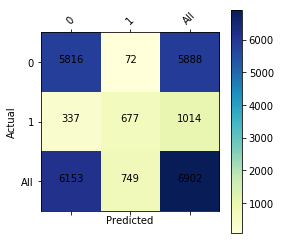


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5888
          1       0.90      0.67      0.77      1014

avg / total       0.94      0.94      0.94      6902

ACCURACY =  0.9407418139669661
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 1113, '6eri.cif1_AA': 1011, '5xxb.cif1_1': 844, '5xy3.cif1_1': 762, '6ek0.cif1_S2': 550, '5xxu.cif1_2': 474, '5ngm.cif1_Aa': 461, '5t5h.cif1_B': 282, '6gaz.cif1_AA': 277, '3j7o.cif1_7': 58, '5xy3.cif1_3': 54, '3mxh.cif1_R': 47, '4kqy.cif1_A': 45, '6eri.cif1_Ax': 42, '2qwy.cif1_C': 37, '2r8s.cif1_R': 34, '3v7e.cif1_C': 33, '5t83.cif1_A': 33, '5ccb.cif1_N': 31, '1mfq.cif1_A': 30, '4yye.cif1_C': 29, '6d9j.cif1_8': 27, '4v8n.cif1_CV': 26, '6az3.cif1_4': 26, '3al0.cif1_E': 25, '3d2v.cif1_A': 25, '6eri.cif1_AB': 25, '3amu.cif1_B': 24, '3kfu.cif1_L': 24, '5nwq.cif1_A': 24, '5ool.cif1_B': 22, '5ktj.cif1_A': 21, '5oql.cif1_2': 21, '4v90.cif1_AV': 20, '5xxb.cif1_4': 20, '1y26.cif1_X': 19, '3g

111 A.G.135.A.C.162.A.A.213. cWW_-_tWW 10.64_5.99_12.94 PROBA:  0.1876438892065137
111 A.G.136.A.C.161.A.A.214. cWW_-_tSS 10.37_5.62_8.32 PROBA:  0.2483465835061526
111 A.A.149.A.G.198.A.A.201. -_tSH_tWW 6.86_8.91_13.83 PROBA:  0.3294659201266731
111 A.G.150.A.G.197.A.C.202. cSS_cWW_tSW 4.4_10.49_8.8 PROBA:  0.338945156967134
CONFUSION MATRIX By chain:  1mfq.cif1_A
[[25  0]
 [ 4  1]]

112 A.A.12.A.U.42.A.U.66. -_-_cWW 13.21_5.05_10.85 PROBA:  0.5436815651655124
111 A.A.14.A.G.37.A.C.44. tWS_cWW_- 9.42_10.92_11.33 PROBA:  0.4783371934920531
111 A.G.39.A.U.42.A.C.65. tSW_-_cWW 7.83_8.37_10.74 PROBA:  0.1078415269672038
CONFUSION MATRIX By chain:  3ivn.cif1_A
[[14  1]
 [ 2  1]]

CONFUSION MATRIX By chain:  3k0j.cif1_E
[[8 0]
 [0 2]]

100 S6.U.55.S6.C.56.S6.C.62. -_-_- 7.86_20.61_12.86 PROBA:  0.5558100430581209
111 S6.G.29.S6.G.31.S6.C.39. cSH_cWW_cWW 8.3_10.52_11.42 PROBA:  0.47180955558307686
111 S6.A.50.S6.C.62.S6.U.64. cWW_-_cWW 13.25_9.41_10.25 PROBA:  0.47538689866581324
CONFUSION M

112 1L.U.8.1L.C.68.1L.A.69. -_cSH_- 17.67_6.47_22.13 PROBA:  0.6837619187480918
111 1L.U.8.1L.A.14.1L.U.59. tWH_tWW_- 9.5_9.85_6.15 PROBA:  0.0908203731760178
CONFUSION MATRIX By chain:  5ibb.cif1_1L
[[6 1]
 [1 0]]

CONFUSION MATRIX By chain:  5oql.cif1_2
[[18  0]
 [ 0  3]]

0 A.A.22.A.A.27.A.C.30. -_-_- 12.86_11.07_7.63 PROBA:  0.6516330069517461
112 A.C.15.A.A.35.A.G.37. -_-_cWW 13.65_9.34_10.6 PROBA:  0.7564056728183979
112 A.A.12.A.A.13.A.U.38. -_-_cWW 5.3_10.13_10.9 PROBA:  0.7464328385989032
123 A.A.14.A.C.15.A.U.16. -_-_- 5.17_5.81_10.52 PROBA:  0.6048759160218253
CONFUSION MATRIX By chain:  1s03.cif1_A
[[9 4]
 [0 3]]

CONFUSION MATRIX By chain:  4bw0.cif1_A
[[1 0]
 [0 1]]

CONFUSION MATRIX By chain:  5c45.cif1_X
[[3 0]
 [0 1]]

111 1L.U.8.1L.A.14.1L.C.48. tWH_tWW_- 9.33_11.54_4.57 PROBA:  0.034723129587941236
CONFUSION MATRIX By chain:  5ib8.cif1_1L
[[5 0]
 [1 0]]

111 B.A.21.B.U.48.B.U.75. tW._cWS_cWW 10.92_6.06_10.56 PROBA:  0.2595864981480982
CONFUSION MATRIX By chain:  5swd

111 2A.U.9.2A.A.2629.2A.A.2801.A tWW_tHS_t.W 11.02_10.72_10.03 PROBA:  0.03504870546766839
111 2A.G.55.2A.C.115.2A.A.127. cWW_-_tSS 10.34_5.72_8.06 PROBA:  0.46502787252932515
111 2A.A.141.2A.C.1408.2A.G.1594. cWS_cWW_tW. 5.6_10.57_13.05 PROBA:  0.2841268265158117
111 2A.A.142.2A.C.1407.2A.G.1595. -_cWW_tSS 5.7_10.48_8.21 PROBA:  0.1942436736177244
111 2A.A.182.2A.G.215.2A.C.433. cWW_-_cSS 13.11_10.47_5.77 PROBA:  0.45788407113901997
111 2A.G.187.2A.C.209.2A.A.1365. cWW_-_cSW 10.74_12.73_6.35 PROBA:  0.42296741528561305
111 2A.U.200.2A.G.250.2A.G.386. tWW_-_cWW 11.14_12.82_7.62 PROBA:  0.2505870029358359
111 2A.A.227.2A.G.410.2A.C.417. tWS_cWW_- 9.11_10.87_11.61 PROBA:  0.484463540643605
111 2A.G.266.2A.A.283.2A.C.426. tSW_-_cWW 9.55_10.48_10.88 PROBA:  0.2707462788245133
111 2A.A.443.2A.C.1200.2A.G.1245. -_cWW_tSS 5.49_10.53_8.33 PROBA:  0.34669906627919317
111 2A.G.465.2A.C.683.2A.G.794. cSS_cWW_- 5.83_10.76_13.5 PROBA:  0.47384965177752475
111 2A.C.542.2A.G.551.2A.A.1220. cWW_cSW_- 

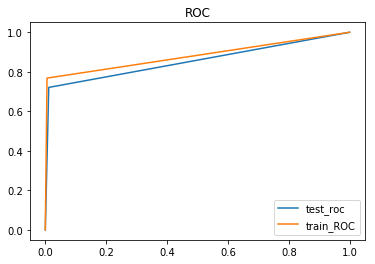

Probability density for train


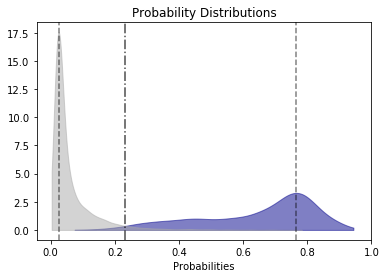

Probability density for test


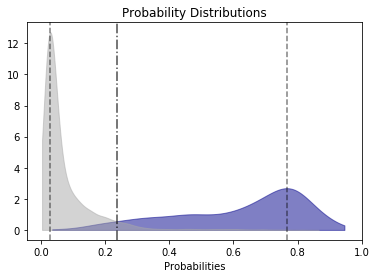


[[5821   67]
 [ 283  731]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5821   67  5888
1           283  731  1014
All        6104  798  6902


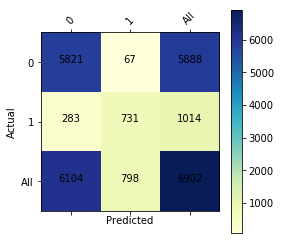


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5888
          1       0.92      0.72      0.81      1014

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.949290060851927
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 1099, '6ha1.cif1_A': 1023, '5tbw.cif1_1': 932, '4v88.cif1_A6': 640, '5o5j.cif1_A': 574, '6gaw.cif1_BA': 539, '6az3.cif1_1': 397, '3j9m.cif1_AA': 320, '5oql.cif1_1': 158, '1nbs.cif1_B': 65, '3igi.cif1_A': 62, '5j7l.cif1_DB': 56, '6az3.cif1_8': 53, '5ml7.cif1_B': 46, '3ivk.cif1_M': 43, '3hhn.cif1_E': 38, '1yfg.cif1_A': 37, '4uyk.cif1_R': 34, '1h4s.cif1_T': 33, '4lck.cif1_F': 32, '4aob.cif1_A': 30, '4y1j.cif1_A': 29, '3wqy.cif1_C': 28, '6cb3.cif1_B': 27, '3wfs.cif1_A': 26, '1fir.cif1_A': 25, '1qtq.cif1_B': 25, '3ski.cif1_A': 25, '6ck5.cif1_A': 25, '1gax.cif1_D': 24, '3j79.cif1_C': 24, '5axm.cif1_P': 23, '3d0u.cif1_A': 21, '6az3.cif1_5': 21, '1ser.cif1_T': 20, '3oxe.cif1_A': 20, '3w3s.ci

123 P.U.8.P.G.45.P.G.46. -_-_- 13.48_8.12_7.89 PROBA:  0.6427155451445442
CONFUSION MATRIX By chain:  5axm.cif1_P
[[18  1]
 [ 0  4]]

111 DA.G.54.DA.C.116.DA.A.126. cWW_-_t.W 10.69_5.68_12.07 PROBA:  0.4552806987145573
111 DA.G.60.DA.C.66.DA.G.88. ..._cWW_cWH 14.38_10.53_11.26 PROBA:  0.4921455923723751
111 DA.U.62.DA.A.64.DA.U.90. cWH_cWW_- 9.0_10.61_12.96 PROBA:  0.3863249146220917
111 DA.G.80.DA.C.106.DA.A.294. cWW_-_tSS 10.64_5.9_8.13 PROBA:  0.2577652918346595
111 DA.U.200.DA.G.250.DA.G.386. tWW_-_cWW 10.94_13.13_8.08 PROBA:  0.3276317474197714
111 DA.C.228.DA.U.416.DA.A.2407. -_cWW_cHS 12.29_10.66_7.66 PROBA:  0.36910769189069503
111 DA.G.245.DA.C.253.DA.A.384. cWW_-_tSS 10.65_6.97_7.78 PROBA:  0.20524851740955305
111 DA.C.385.DA.U.390.DA.G.411. -_cWS_cWW 9.11_7.05_10.83 PROBA:  0.22531423590629424
111 DA.A.443.DA.C.1200.DA.G.1245. -_cWW_tSS 5.28_10.25_8.42 PROBA:  0.4092327830788402
111 DA.G.465.DA.U.683.DA.A.794. cSS_cWW_- 5.87_10.93_13.58 PROBA:  0.4250458311633269
111 DA.A.53

CONFUSION MATRIX By chain:  4jxz.cif1_B
[[8 0]
 [0 2]]

112 A.G.998.A.G.1068.A.C.1077. -_cWW_- 89.33_10.77_85.69 PROBA:  0.5469006023008444
111 A.U.41.A.A.397.A.A.527. tWW_cHS_- 11.32_7.76_8.87 PROBA:  0.4716178673275512
111 A.A.55.A.U.110.A.A.313. cHS_cWW_- 7.65_10.64_12.5 PROBA:  0.4434304608951472
111 A.A.69.A.C.213.A.G.218. -_cWW_tWS 6.54_10.61_8.77 PROBA:  0.31932860862179974
111 A.G.108.A.A.315.A.U.328. cWW_cHH_- 12.77_7.94_16.02 PROBA:  0.21637571550061083
111 A.U.125.A.G.232.A.G.262. cWW_tSW_- 10.68_8.45_13.32 PROBA:  0.35616501163755293
111 A.G.126.A.C.191.A.G.196. -_cWW_cHS 11.29_10.55_5.9 PROBA:  0.32142224176461637
111 A.G.145.A.A.171.A.A.1429. cWW_-_cSW 13.21_15.58_6.23 PROBA:  0.2099274347634936
111 A.C.291.A.G.309.A.A.587. cWW_cSW_- 10.32_9.94_12.85 PROBA:  0.37702285396114016
111 A.G.297.A.A.300.A.C.544. tSH_cSW_- 9.34_7.96_16.52 PROBA:  0.33449552883859035
111 A.C.906.A.G.1375.A.A.1486. cWW_cSS_- 10.73_5.9_7.82 PROBA:  0.3704593704853158
111 A.A.960.A.G.1298.A.A.1342. 

111 1.G.1202.1.C.1215.1.U.1401. cWW_-_tSW 11.2_9.7_8.22 PROBA:  0.2353986143444779
111 1.C.1203.1.G.1214.1.G.1226. cWW_cSW_- 10.7_6.16_13.36 PROBA:  0.2947880639206947
111 1.G.1556.1.A.1575.1.U.1618. cWW_-_cSW 12.49_10.96_5.85 PROBA:  0.24751231433266066
110 1.A.384.1.A.389.1.A.391. tWH_-_- 12.38_14.78_24.93 PROBA:  0.7248492245275614
110 1.G.393.1.A.405.1.G.435. -_-_- 10.67_40.8_45.01 PROBA:  0.807861790717748
110 1.G.1202.1.C.1215.1.A.1422. cWW_-_- 11.2_57.92_58.37 PROBA:  0.5463217259744814
CONFUSION MATRIX By chain:  6az3.cif1_1
[[334   6]
 [ 16  41]]

112 A.G.37.A.G.41.A.G.42. cWH_-_- 11.59_6.01_14.6 PROBA:  0.6516898937687717
111 A.G.17.A.A.43.A.A.87. cWW_-_cSW 13.48_14.27_9.97 PROBA:  0.32325605167215754
123 A.C.20.A.C.21.A.A.43. -_-_- 5.51_8.06_8.58 PROBA:  0.7139092667178434
CONFUSION MATRIX By chain:  6ck5.cif1_A
[[19  2]
 [ 1  3]]

CONFUSION MATRIX By chain:  5b63.cif1_D
[[15  0]
 [ 0  3]]

CONFUSION MATRIX By chain:  3hjw.cif1_D
[[1]]

111 E.A.8.E.C.101.E.G.131. cSS_cWW_- 3

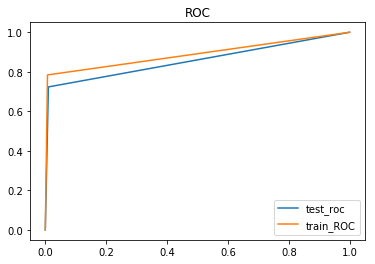

Probability density for train


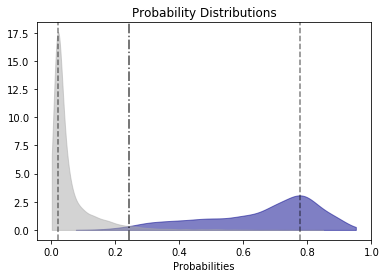

Probability density for test


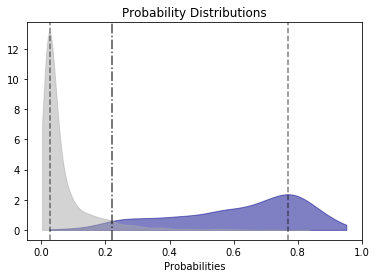


[[5826   60]
 [ 281  735]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5826   60  5886
1           281  735  1016
All        6107  795  6902


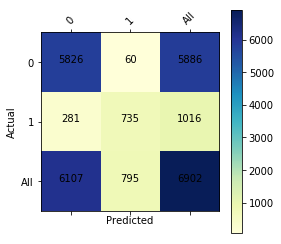


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5886
          1       0.92      0.72      0.81      1016

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.9505940307157346
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 1042, '5o60.cif1_A': 1039, '4wf9.cif1_X': 943, '5j7l.cif1_AA': 649, '4lfb.cif1_A': 587, '6eri.cif1_BA': 541, '5an9.cif1_N': 413, '6az3.cif1_2': 286, '5t2a.cif1_B': 250, '2a64.cif1_A': 61, '5t5h.cif1_D': 55, '3pdr.cif1_X': 51, '5tbw.cif1_AS': 46, '4yaz.cif1_R': 43, '4ycp.cif1_B': 41, '1c0a.cif1_B': 36, '3ndb.cif1_M': 33, '5wt1.cif1_C': 33, '4pr6.cif1_B': 31, '4prf.cif1_B': 31, '3iwn.cif1_A': 29, '4qk9.cif1_A': 28, '2azx.cif1_D': 26, '2qus.cif1_A': 26, '5tbw.cif1_4': 26, '3skl.cif1_B': 25, '5l4o.cif1_A': 25, '5mgp.cif1_x': 25, '1evv.cif1_A': 24, '1qf6.cif1_B': 24, '5o2r.cif1_x': 23, '4rzd.cif1_A': 21, '6gaz.cif1_AV': 21, '5e81.cif1_2K': 20, '5wwt.cif1_C': 20, '6cfj.cif1_1x': 20, '1b23

123 C.A.134.C.A.140.C.G.149. -_-_- 22.78_17.72_26.99 PROBA:  0.5684703854501223
CONFUSION MATRIX By chain:  1hc8.cif1_C
[[12  1]
 [ 0  3]]

112 B.G.10.B.G.22.B.G7M.46. -_tHW_- 16.9_10.83_11.09 PROBA:  0.5830527291415035
CONFUSION MATRIX By chain:  1qf6.cif1_B
[[19  1]
 [ 0  4]]

111 B.A.31.B.G.52.B.C.59. tWS_cWW_- 9.94_10.81_9.34 PROBA:  0.4948897758127332
111 B.G.32.B.G.33.B.U.51. cSH_cWW_cWW 6.87_10.35_11.78 PROBA:  0.40446041301597885
CONFUSION MATRIX By chain:  3skl.cif1_B
[[21  0]
 [ 2  2]]

120 D.U.909.D.U.959.D.C.960. -_-_- 7.42_7.04_7.84 PROBA:  0.6423405703931153
112 D.G.915.D.C.922.D.A.925. tSW_-_- 8.55_10.07_8.31 PROBA:  0.6812449215691934
111 D.U.909.D.G.913.D.A.925. tHW_tSH_- 12.41_9.62_14.43 PROBA:  0.45725077802838093
111 D.G.915.D.C.922.D.C.960. tSW_t.W_tWW 8.55_9.79_10.1 PROBA:  0.21568682403192152
CONFUSION MATRIX By chain:  1wz2.cif1_D
[[8 2]
 [2 0]]

112 2K.C.13.2K.G.23.2K.G.46. cWW_-_- 10.45_14.36_17.37 PROBA:  0.6746841248426964
CONFUSION MATRIX By chain:  5e81.ci

112 L5.G.3907.L5.C.3924.L5.G.4187. -_cWW_- 36.31_10.8_33.42 PROBA:  0.5285257315166867
111 L5.A.62.L5.U.77.L5.A.336. cWS_tWW_- 5.77_11.13_13.94 PROBA:  0.4273494086721096
111 L5.A.70.L5.G.314.L5.C.323. tWS_cWW_- 9.52_10.6_10.82 PROBA:  0.42055834688454086
111 L5.C.185.L5.U.187.L5.G.1366. cSS_cHW_- 5.23_9.56_11.9 PROBA:  0.12073256025683354
111 L5.A.197.L5.A.227.L5.G.241. -_tHS_cHH 16.68_9.75_13.17 PROBA:  0.36367120650897616
111 L5.A.295.L5.U.4353.L5.U.4361. -_cWW_cWS 12.68_9.1_9.83 PROBA:  0.31654948695938645
111 L5.A.349.L5.G.2294.L5.C.2340. cSS_cWW_- 6.24_10.35_9.01 PROBA:  0.3881499141594148
111 L5.A.371.L5.U.1531.L5.A.1643. cSS_cWW_- 6.01_10.86_13.88 PROBA:  0.3642243030669615
111 L5.G.444.L5.A.1303.L5.A.2313. cWW_-_tSS 12.49_7.51_8.29 PROBA:  0.23359751645593488
111 L5.C.489.L5.G.664.L5.G.666. cWW_cSH_- 11.45_7.25_11.65 PROBA:  0.478623933087587
111 L5.C.501.L5.G.507.L5.C.651. cWH_cWW_- 11.72_10.82_14.9 PROBA:  0.4526384447893275
111 L5.C.704.L5.G.708.L5.C.1289. cWH_cWW_- 12.29_1

CONFUSION MATRIX By chain:  5an9.cif1_N
[[353   1]
 [ 18  41]]

CONFUSION MATRIX By chain:  5wt1.cif1_C
[[28  0]
 [ 0  5]]

CONFUSION MATRIX By chain:  4qk9.cif1_A
[[24  0]
 [ 0  4]]

112 A.U.43.A.C.45.A.G.81. cWH_-_- 9.36_7.19_12.22 PROBA:  0.6405890922708509
111 A.A.13.A.C.34.A.G.78. tSH_cWW_- 9.54_11.15_9.33 PROBA:  0.2269415036252031
110 A.A.13.A.A.15.A.C.34. -_-_tSH 12.09_7.03_9.54 PROBA:  0.7479778575058486
CONFUSION MATRIX By chain:  3iwn.cif1_A
[[22  2]
 [ 1  4]]

120 AY.G.6.AY.G.15.AY.G.24. -_-_- 15.92_17.38_20.75 PROBA:  0.5259262212678493
120 AY.C.11.AY.A.22.AY.A.59. -_-_- 15.49_12.95_20.41 PROBA:  0.649199781499525
0 AY.C.27.AY.G.42.AY.G.62. -_-_- 12.97_40.53_38.72 PROBA:  0.5034784331566265
112 AY.U.20.AY.G.24.AY.A.59. -_-_tHW 20.24_21.22_11.49 PROBA:  0.6274262993479459
112 AY.G.9.AY.G.24.AY.A.59. tWW_-_- 12.26_21.22_14.23 PROBA:  0.6530875285350981
100 AY.C.11.AY.U.46.AY.A.47. -_-_- 15.17_7.99_21.78 PROBA:  0.6282603286279308
CONFUSION MATRIX By chain:  4v9i.cif1_AY
[[2 

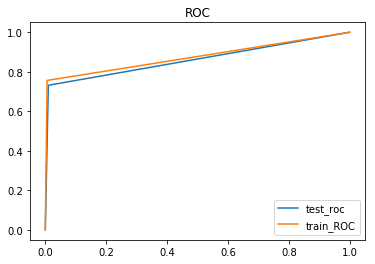

Probability density for train


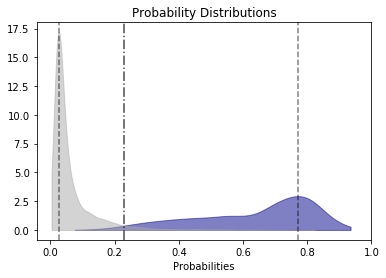

Probability density for test


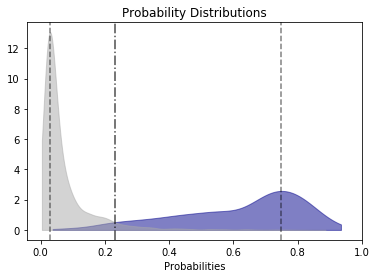


[[5829   59]
 [ 272  742]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5829   59  5888
1           272  742  1014
All        6101  801  6902


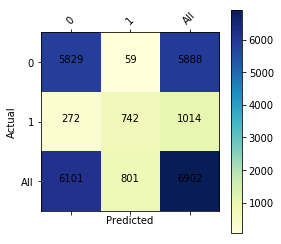


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5888
          1       0.93      0.73      0.82      1014

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.9520428861199652
-----------------


In [6]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.888603330056089

AUC =  0.8262825897943076


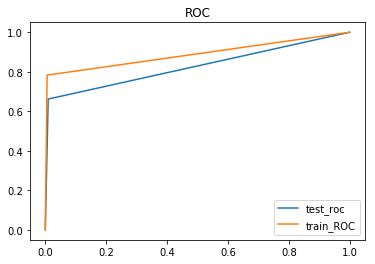

Probability density for train


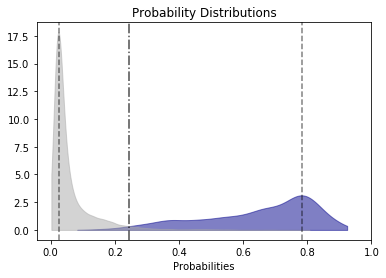

Probability density for test


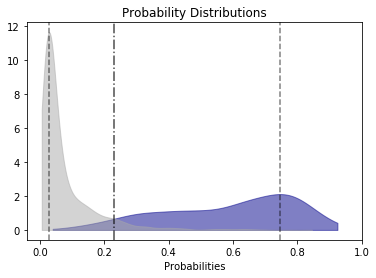


[[2914   28]
 [ 172  337]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2914   28  2942
1           172  337   509
All        3086  365  3451


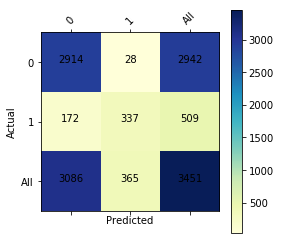

REPORT
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2942
          1       0.92      0.66      0.77       509

avg / total       0.94      0.94      0.94      3451

ACCURACY 0.9420457838307736
-----------------

AUC_TRAIN =  0.8845561672807002

AUC =  0.8454218979753422


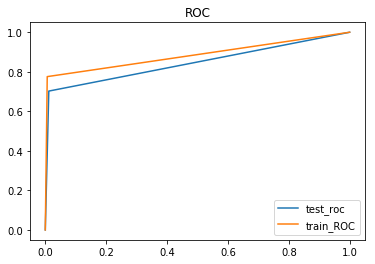

Probability density for train


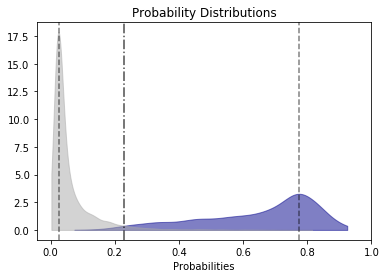

Probability density for test


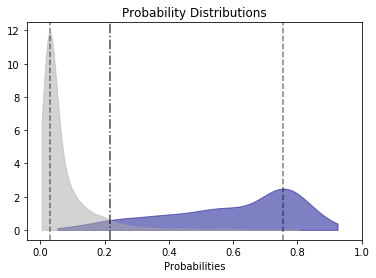


[[2913   34]
 [ 150  354]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2913   34  2947
1           150  354   504
All        3063  388  3451


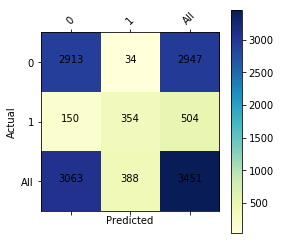

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2947
          1       0.91      0.70      0.79       504

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9466821211243118
-----------------

AUC_TRAIN =  0.882346680760463

AUC =  0.8662189731383884


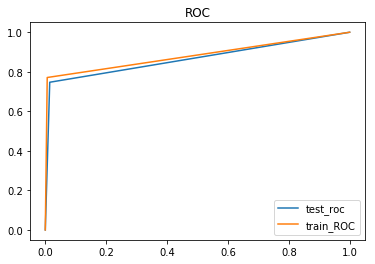

Probability density for train


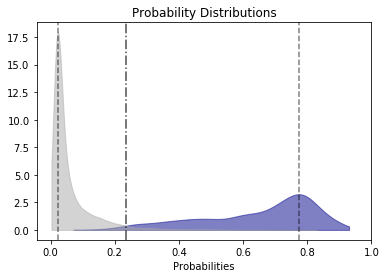

Probability density for test


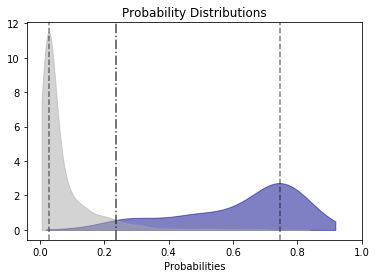


[[2898   43]
 [ 129  381]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2898   43  2941
1           129  381   510
All        3027  424  3451


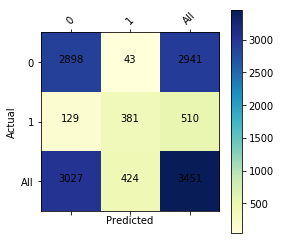

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2941
          1       0.90      0.75      0.82       510

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9501593740944654
-----------------

AUC_TRAIN =  0.8831396647808143

AUC =  0.8661301502246037


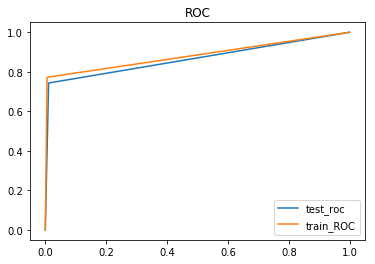

Probability density for train


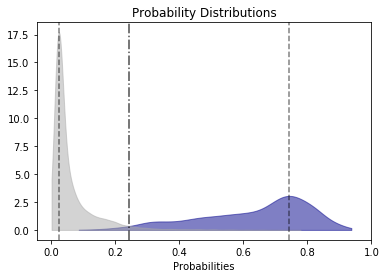

Probability density for test


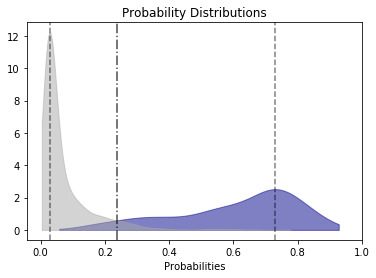


[[2910   32]
 [ 131  379]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2910   32  2942
1           131  379   510
All        3041  411  3452


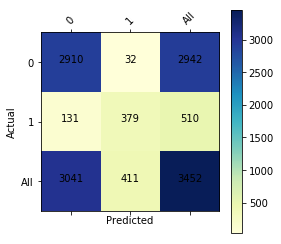

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2942
          1       0.92      0.74      0.82       510

avg / total       0.95      0.95      0.95      3452

ACCURACY 0.9527809965237544
-----------------

AUC_TRAIN =  0.8849303435866553

AUC =  0.842174210257357


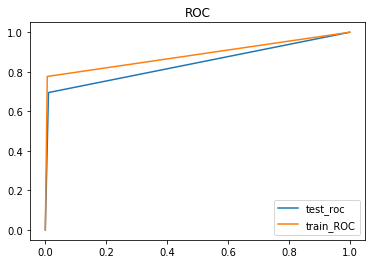

Probability density for train


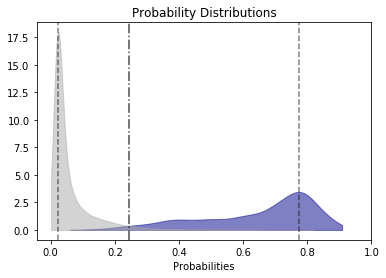

Probability density for test


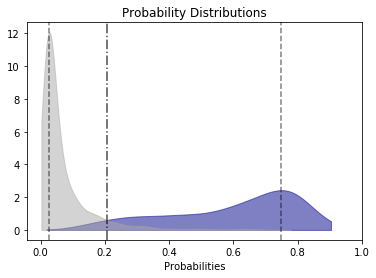


[[2912   31]
 [ 155  353]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2912   31  2943
1           155  353   508
All        3067  384  3451


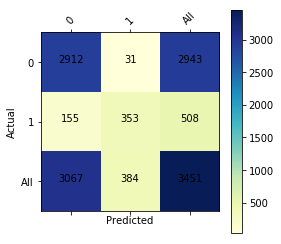

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2943
          1       0.92      0.69      0.79       508

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9461025789626195
-----------------

AUC_TRAIN =  0.8834501593731675

AUC =  0.86532168952887


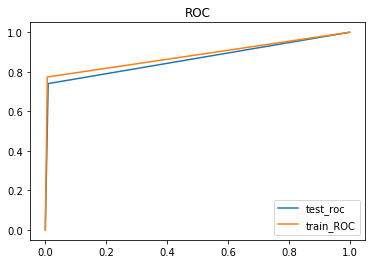

Probability density for train


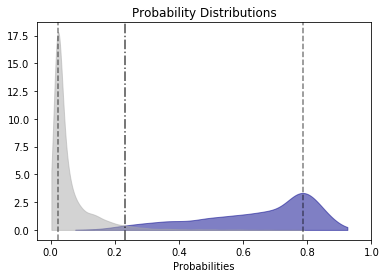

Probability density for test


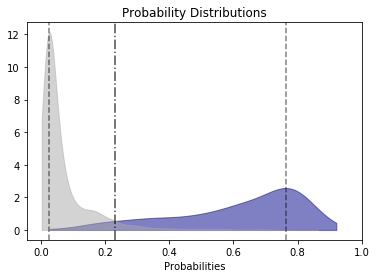


[[2915   28]
 [ 132  376]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2915   28  2943
1           132  376   508
All        3047  404  3451


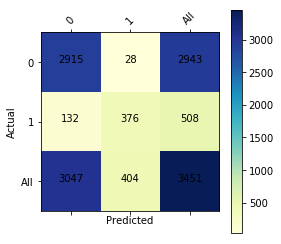

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2943
          1       0.93      0.74      0.82       508

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9536366270646189
-----------------

AUC_TRAIN =  0.8824834083612887

AUC =  0.8296098578137686


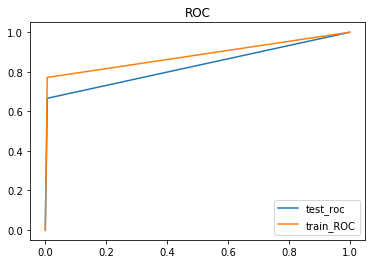

Probability density for train


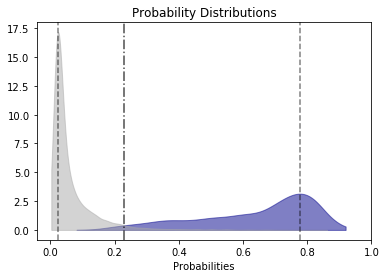

Probability density for test


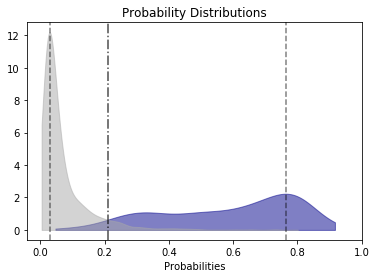


[[2928   20]
 [ 168  335]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2928   20  2948
1           168  335   503
All        3096  355  3451


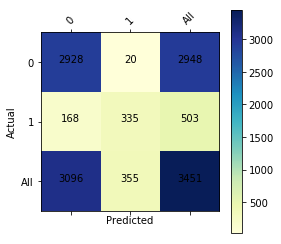

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2948
          1       0.94      0.67      0.78       503

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9455230368009273
-----------------

AUC_TRAIN =  0.8845638718540831

AUC =  0.8726509052576379


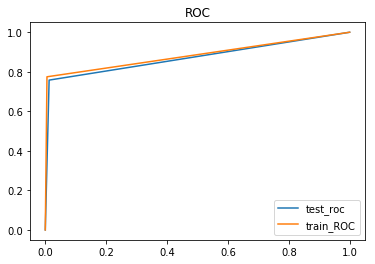

Probability density for train


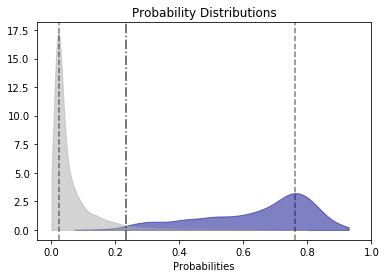

Probability density for test


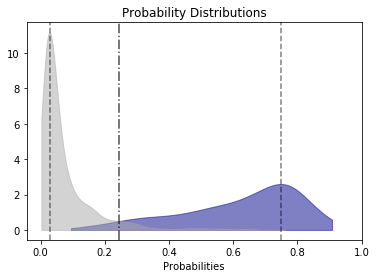


[[2906   37]
 [ 123  385]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2906   37  2943
1           123  385   508
All        3029  422  3451


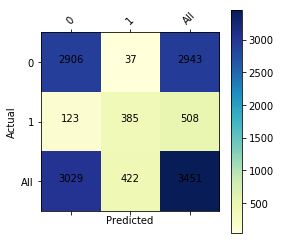

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2943
          1       0.91      0.76      0.83       508

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9536366270646189
-----------------

AUC_TRAIN =  0.8843468661114121

AUC =  0.8598139672168806


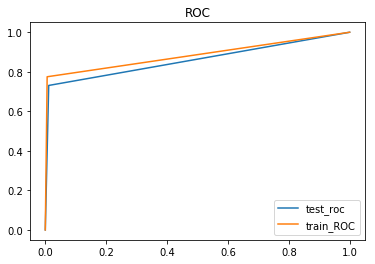

Probability density for train


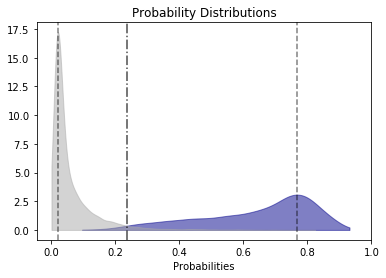

Probability density for test


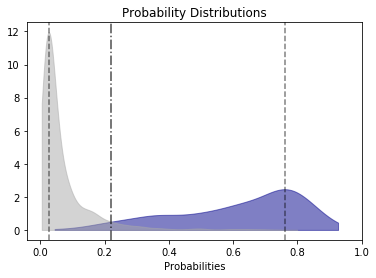


[[2909   33]
 [ 137  372]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2909   33  2942
1           137  372   509
All        3046  405  3451


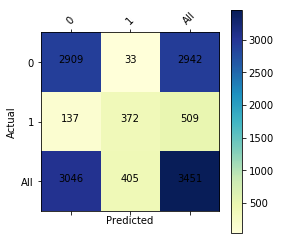

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2942
          1       0.92      0.73      0.81       509

avg / total       0.95      0.95      0.95      3451

ACCURACY 0.9507389162561576
-----------------

AUC_TRAIN =  0.8772488166651393

AUC =  0.8619223722032645


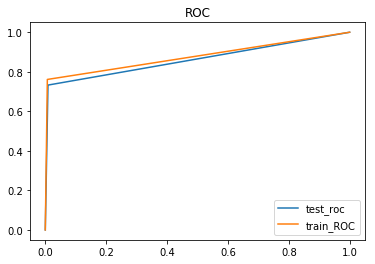

Probability density for train


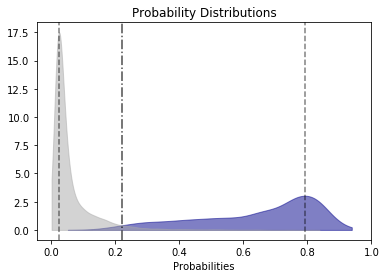

Probability density for test


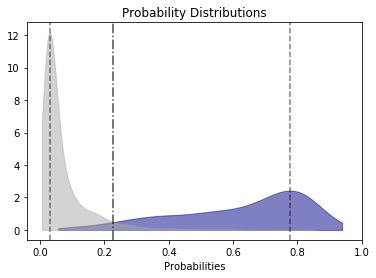


[[2919   26]
 [ 135  370]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          2919   26  2945
1           135  370   505
All        3054  396  3450


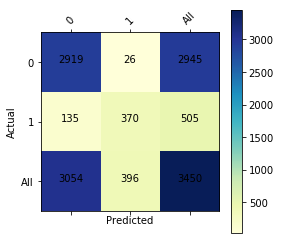

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2945
          1       0.93      0.73      0.82       505

avg / total       0.95      0.95      0.95      3450

ACCURACY 0.9533333333333334
-----------------


In [7]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.8860487874603091

AUC =  0.8286342689568496


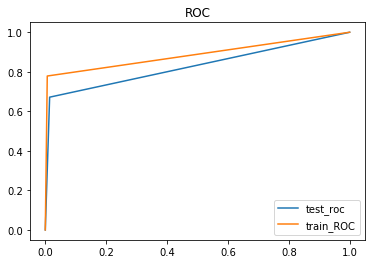

Probability density for train


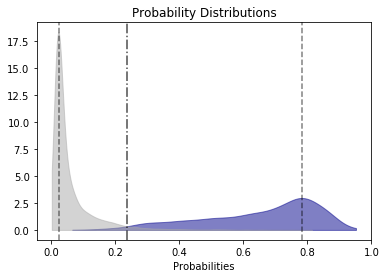

Probability density for test


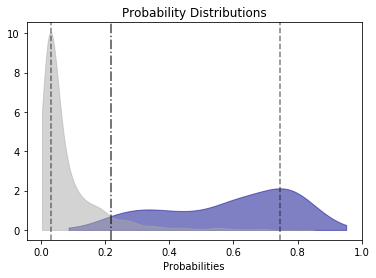


[[1932   28]
 [ 112  229]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1932   28  1960
1           112  229   341
All        2044  257  2301


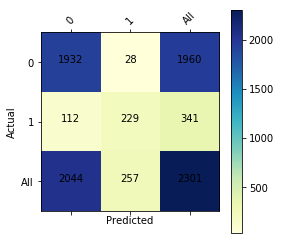

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.89      0.67      0.77       341

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.9391568883094307
-----------------

AUC_TRAIN =  0.883284314337792

AUC =  0.8540176509787463


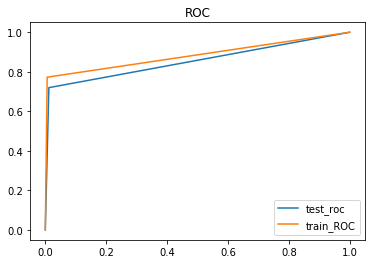

Probability density for train


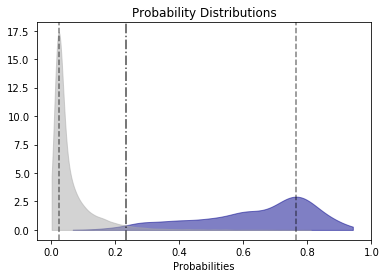

Probability density for test


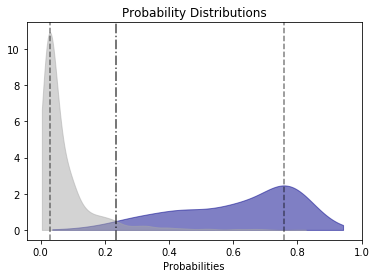


[[1938   23]
 [  95  244]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1938   23  1961
1            95  244   339
All        2033  267  2300


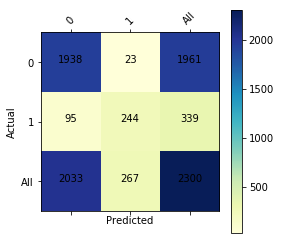

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1961
          1       0.91      0.72      0.81       339

avg / total       0.95      0.95      0.95      2300

ACCURACY 0.948695652173913
-----------------

AUC_TRAIN =  0.8791899186984973

AUC =  0.8418785921059788


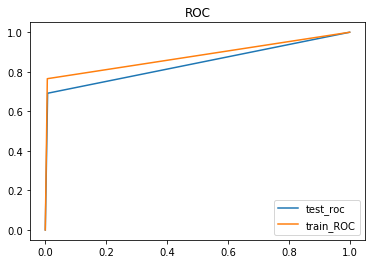

Probability density for train


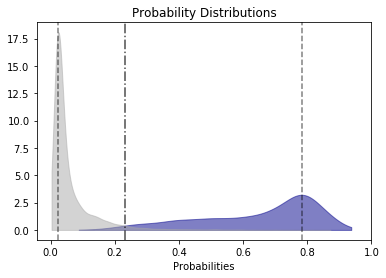

Probability density for test


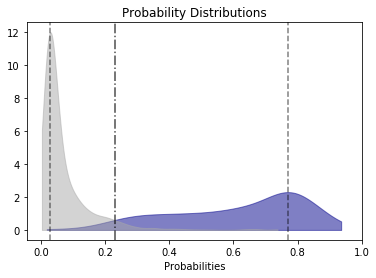


[[1949   15]
 [ 104  233]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1949   15  1964
1           104  233   337
All        2053  248  2301


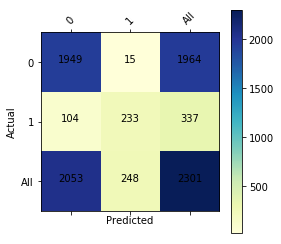

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1964
          1       0.94      0.69      0.80       337

avg / total       0.95      0.95      0.94      2301

ACCURACY 0.9482833550630161
-----------------

AUC_TRAIN =  0.8873368689022219

AUC =  0.8333716723949735


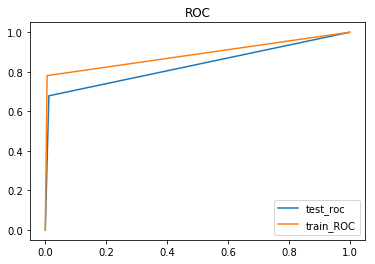

Probability density for train


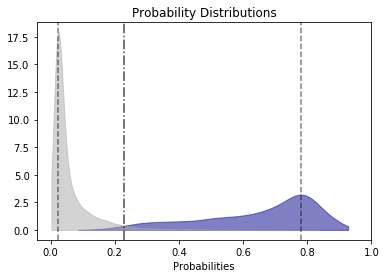

Probability density for test


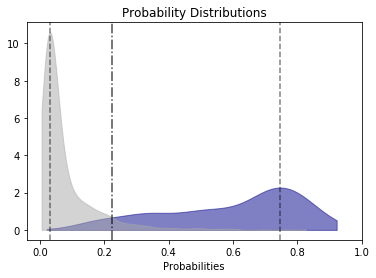


[[1939   23]
 [ 109  230]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1939   23  1962
1           109  230   339
All        2048  253  2301


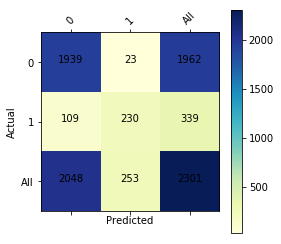

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.91      0.68      0.78       339

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.9426336375488917
-----------------

AUC_TRAIN =  0.8802027778686397

AUC =  0.8442728947059054


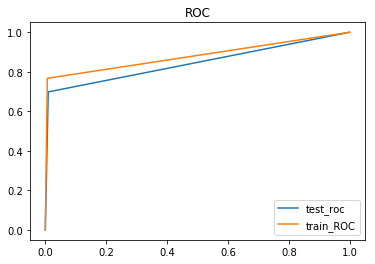

Probability density for train


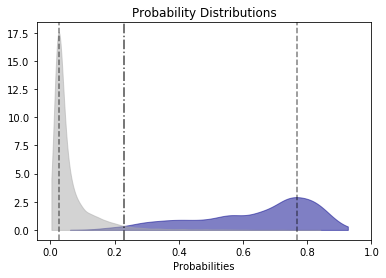

Probability density for test


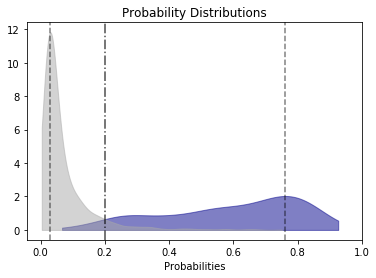


[[1944   19]
 [ 102  236]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1944   19  1963
1           102  236   338
All        2046  255  2301


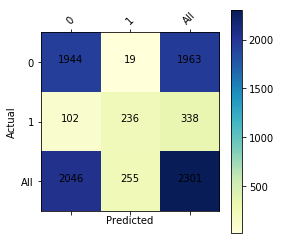

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1963
          1       0.93      0.70      0.80       338

avg / total       0.95      0.95      0.94      2301

ACCURACY 0.9474141677531508
-----------------

AUC_TRAIN =  0.8877237670322656

AUC =  0.8896321968781065


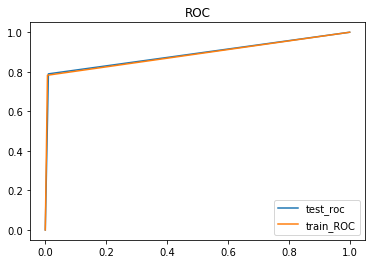

Probability density for train


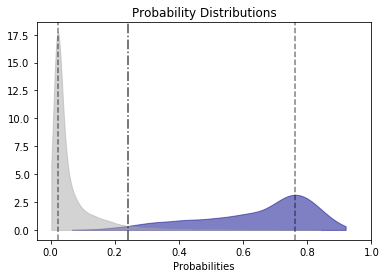

Probability density for test


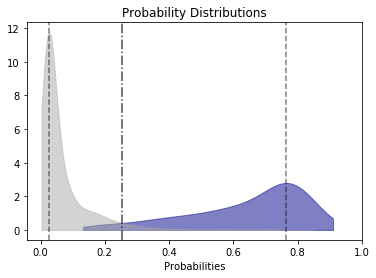


[[1939   20]
 [  72  270]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1939   20  1959
1            72  270   342
All        2011  290  2301


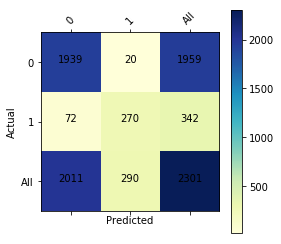

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1959
          1       0.93      0.79      0.85       342

avg / total       0.96      0.96      0.96      2301

ACCURACY 0.9600173837461973
-----------------

AUC_TRAIN =  0.8794827233796699

AUC =  0.8515263457010636


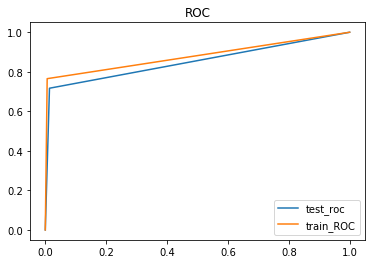

Probability density for train


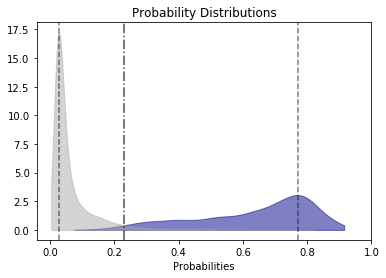

Probability density for test


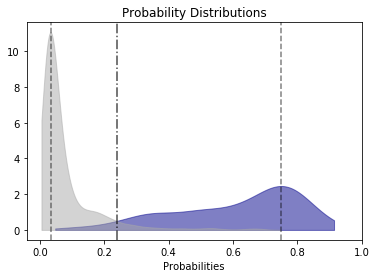


[[1935   27]
 [  96  243]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1935   27  1962
1            96  243   339
All        2031  270  2301


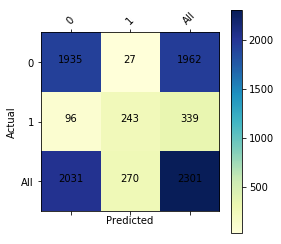

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.90      0.72      0.80       339

avg / total       0.94      0.95      0.94      2301

ACCURACY 0.9465449804432855
-----------------

AUC_TRAIN =  0.8788238707935506

AUC =  0.8869210670012139


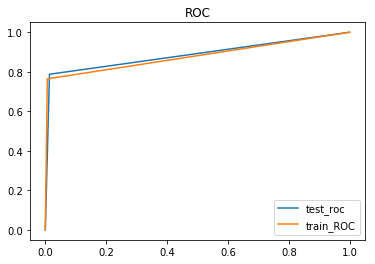

Probability density for train


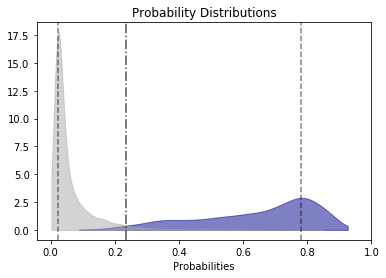

Probability density for test


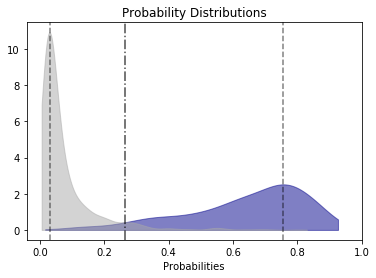


[[1934   27]
 [  72  267]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1934   27  1961
1            72  267   339
All        2006  294  2300


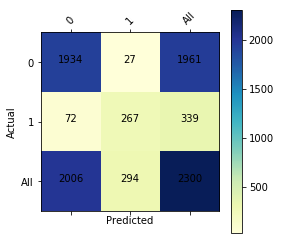

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1961
          1       0.91      0.79      0.84       339

avg / total       0.96      0.96      0.96      2300

ACCURACY 0.9569565217391305
-----------------

AUC_TRAIN =  0.8830682669789282

AUC =  0.8344511086877499


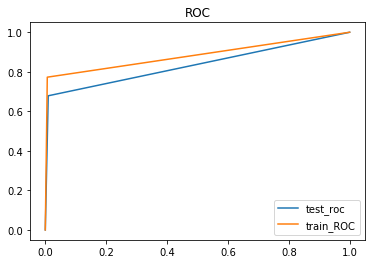

Probability density for train


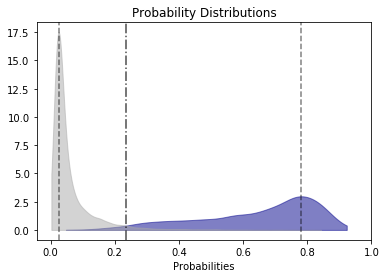

Probability density for test


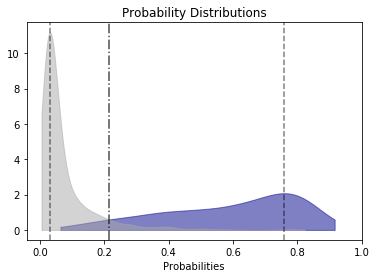


[[1946   19]
 [ 108  228]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1946   19  1965
1           108  228   336
All        2054  247  2301


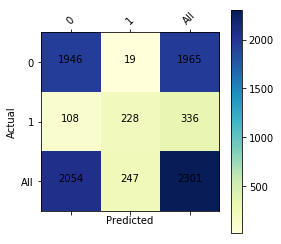

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1965
          1       0.92      0.68      0.78       336

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.944806605823555
-----------------

AUC_TRAIN =  0.8768782326483928

AUC =  0.8614912758996729


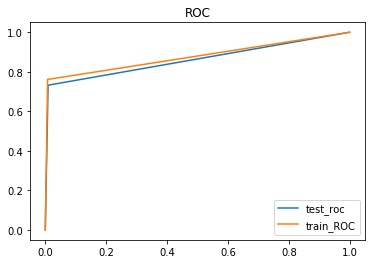

Probability density for train


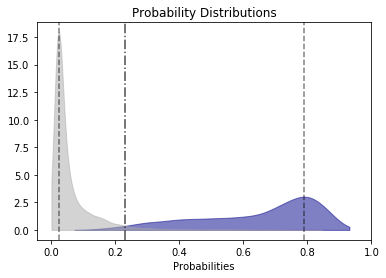

Probability density for test


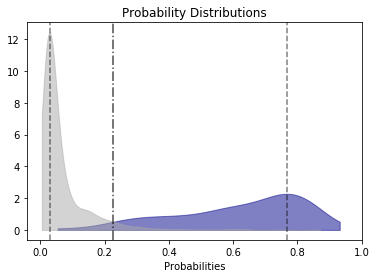


[[1947   18]
 [  90  246]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1947   18  1965
1            90  246   336
All        2037  264  2301


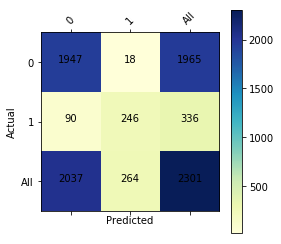

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1965
          1       0.93      0.73      0.82       336

avg / total       0.95      0.95      0.95      2301

ACCURACY 0.9530638852672751
-----------------

AUC_TRAIN =  0.885448718508393

AUC =  0.8479956111132881


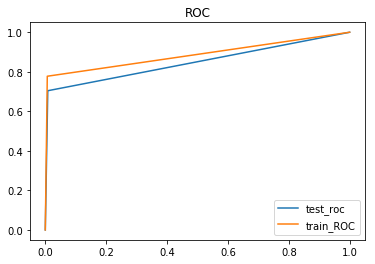

Probability density for train


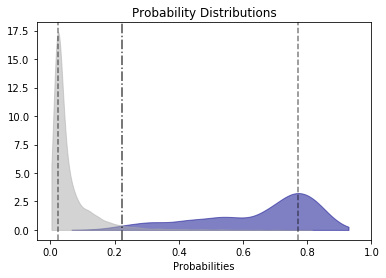

Probability density for test


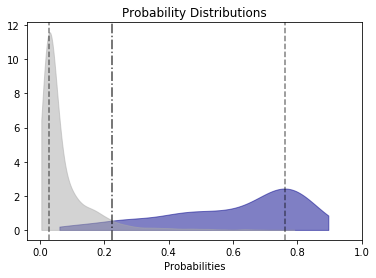


[[1947   16]
 [ 100  238]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1947   16  1963
1           100  238   338
All        2047  254  2301


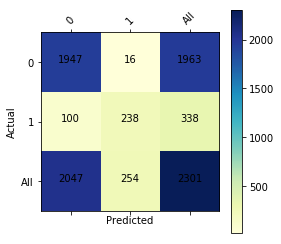

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1963
          1       0.94      0.70      0.80       338

avg / total       0.95      0.95      0.95      2301

ACCURACY 0.949587136027814
-----------------

AUC_TRAIN =  0.8846243686744938

AUC =  0.84273091391302


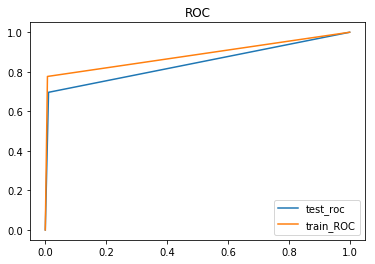

Probability density for train


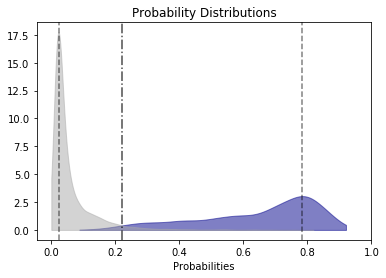

Probability density for test


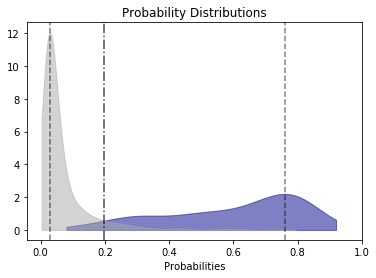


[[1941   21]
 [ 103  236]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1941   21  1962
1           103  236   339
All        2044  257  2301


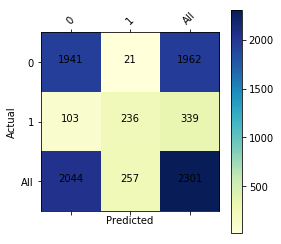

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1962
          1       0.92      0.70      0.79       339

avg / total       0.94      0.95      0.94      2301

ACCURACY 0.9461103867883529
-----------------

AUC_TRAIN =  0.884263829885263

AUC =  0.8883355428543787


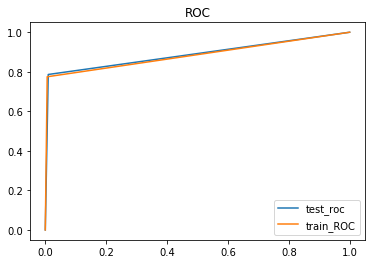

Probability density for train


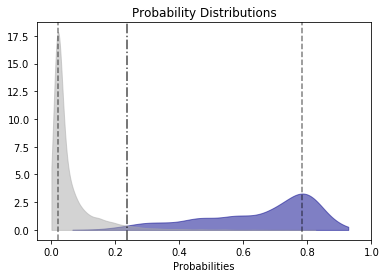

Probability density for test


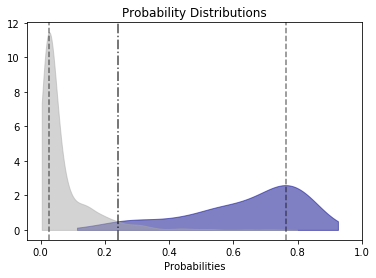


[[1944   19]
 [  72  265]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1944   19  1963
1            72  265   337
All        2016  284  2300


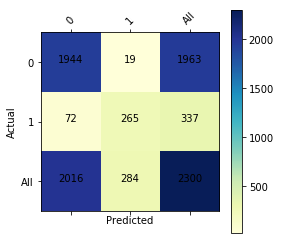

REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1963
          1       0.93      0.79      0.85       337

avg / total       0.96      0.96      0.96      2300

ACCURACY 0.9604347826086956
-----------------

AUC_TRAIN =  0.8820858900381137

AUC =  0.8478415042187954


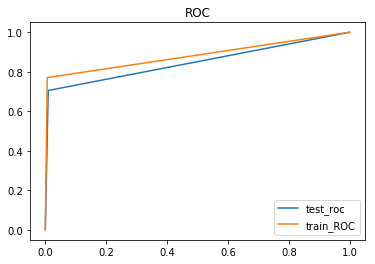

Probability density for train


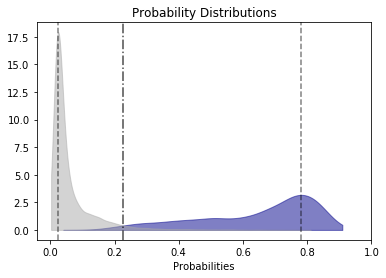

Probability density for test


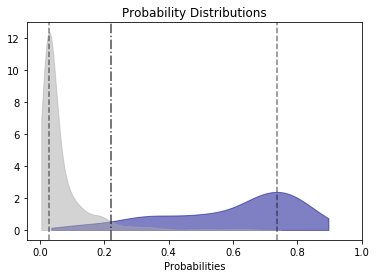


[[1945   19]
 [  99  237]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1945   19  1964
1            99  237   336
All        2044  256  2300


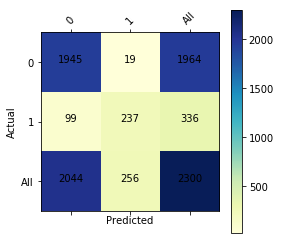

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1964
          1       0.93      0.71      0.80       336

avg / total       0.95      0.95      0.95      2300

ACCURACY 0.948695652173913
-----------------

AUC_TRAIN =  0.881637302602067

AUC =  0.8188676570821949


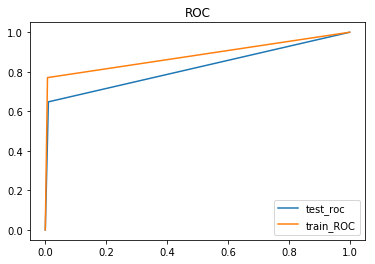

Probability density for train


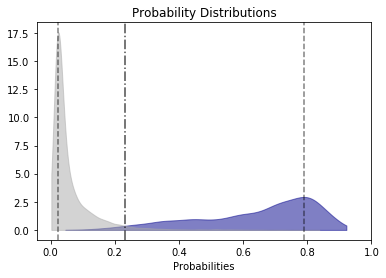

Probability density for test


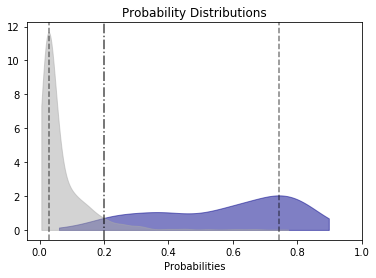


[[1942   20]
 [ 119  219]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          1942   20  1962
1           119  219   338
All        2061  239  2300


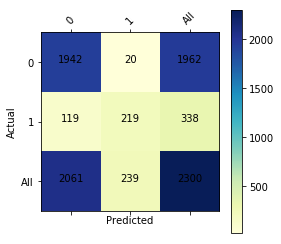

REPORT
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      1962
          1       0.92      0.65      0.76       338

avg / total       0.94      0.94      0.94      2300

ACCURACY 0.9395652173913044
-----------------


In [8]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
